# CDO DATA visualization in Python (Python Kernel)

[Climate Data Online Search](https://www.ncdc.noaa.gov/cdo-web/search)

[GHCN (Global Historical Climatology Network) – Daily Documentation](https://www.ncei.noaa.gov/data/daily-summaries/doc/GHCND_documentation.pdf)

The code reads the data from a CSV file located at '../csv-sample/telaviv.csv' using the pd.read_csv() function from pandas. The data is stored in a pandas DataFrame called data.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read the data
data = pd.read_csv('../csv-sample/telaviv.csv')
data.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,TAVG,TMAX,TMIN
0,IS000002011,"TEL AVIV READING, IS",32.1,34.7831,3.0,1940-01-01,NaN,NaN,NaN
1,IS000002011,"TEL AVIV READING, IS",32.1,34.7831,3.0,1940-01-02,NaN,NaN,NaN
2,IS000002011,"TEL AVIV READING, IS",32.1,34.7831,3.0,1940-01-03,NaN,NaN,NaN
3,IS000002011,"TEL AVIV READING, IS",32.1,34.7831,3.0,1940-01-04,NaN,NaN,NaN
4,IS000002011,"TEL AVIV READING, IS",32.1,34.7831,3.0,1940-01-05,NaN,NaN,NaN


The code filters and processes temperature data for a specific station - ISE00105694, creates a scatter plot of average TMIN and TMAX values over the years, and visualizes the plot with a color gradient indicating the year index using matplotlib and seaborn.

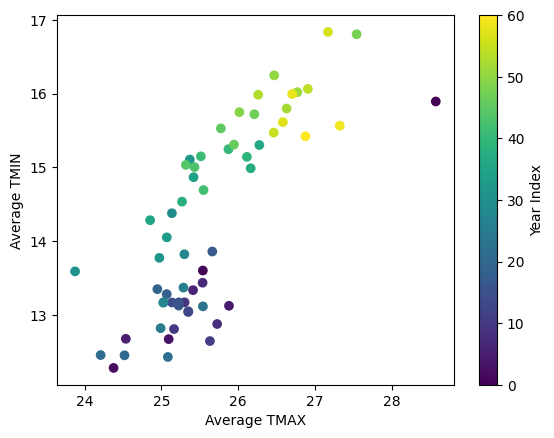

In [3]:
# Filter the data for the station of interest.
df = data[data['STATION'] == 'ISE00105694'].copy()

# Filter out rows where TMIN or TMAX is NaN
df = df.dropna(subset=['TMIN', 'TMAX'])

# Create a 'YEAR' column
df['YEAR'] = df['DATE'].str[:4]

# Group by year and compute average TMIN and TMAX
grouped = df.groupby('YEAR').agg({'TMIN': 'mean', 'TMAX': 'mean'}).reset_index()

# Create a scatter plot with a color gradient
plt.scatter(grouped['TMAX'], grouped['TMIN'], c=range(len(grouped)), cmap='viridis')

# Add a colorbar
cbar = plt.colorbar()
cbar.set_label('Year Index')

plt.xlabel('Average TMAX')
plt.ylabel('Average TMIN')

plt.show()

The code filters temperature data for a specific station - ISE00105694, calculates the average TMAX and TMIN values per year, and creates a scatter plot using plotly.express to visualize the relationship between TMAX and TMIN. The color of the markers represents the year, and the plot is displayed interactively.

In [7]:
#Visualisation libraries
import plotly.express as px

time_series = data[data['STATION'] == 'ISE00105694'].copy()

time_series = time_series[["DATE", 'TMAX', 'TMIN']]
time_series = time_series.astype({'DATE': 'datetime64[ns]'})
time_series['YEAR'] = time_series['DATE'].dt.year

time_series_year = time_series.groupby(['YEAR'])[['TMAX','TMIN']].agg('mean').round(2)

#Creating Average temperature column
time_series_year['TAVG'] = ((time_series_year['TMAX'] + time_series_year['TMIN'])/2).round(2)

# plotting TMAX vs. TMIN with respect to precipitation and temperature by year
img1 = px.scatter(data_frame = time_series_year,
                  x = 'TMAX',
                  y = 'TMIN',
                  color = time_series_year.index,
                  width = 700,
                  height = 600,
                  title = "Average TMAX vs TMIN per Year")

img1.update_traces(marker={'size': 15})
img1.update_layout(xaxis = dict(title = 'TMAX (°C)'),
                   yaxis = dict(title = 'TMIN (°C)'))
img1.show()

The code filters temperature data for a specific station - ISM00040180, converts the 'DATE' column to datetime format, and creates a heatmap plot using seaborn and matplotlib to visualize the temperature variations throughout the years on a day-to-day basis.

The pivot_table() function is used to pivot the df DataFrame, creating a matrix of 'Year' as the index, 'DayOfYear' as the columns, and 'TAVG' as the values. 

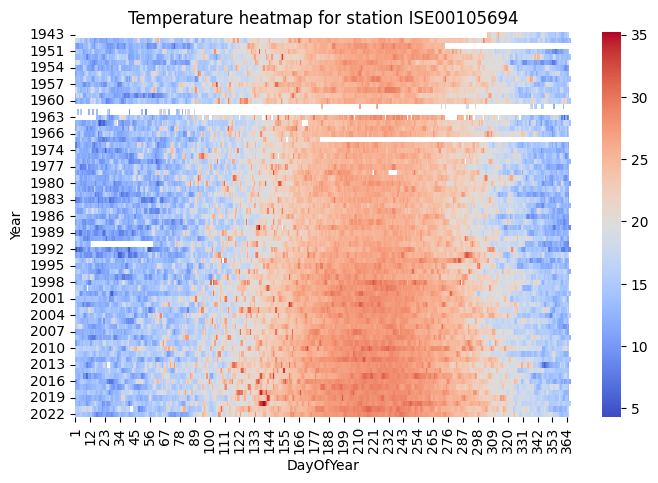

In [8]:
# Filter data for the specific station
df = data[data['STATION'] == 'ISM00040180'].copy()

# Convert DATE column to datetime
df['DATE'] = pd.to_datetime(data['DATE'])

# Extract year and day of year
df['Year'] = df['DATE'].dt.year
df['DayOfYear'] = df['DATE'].dt.dayofyear

df=df.sort_values(by='Year', ascending=False)

# Pivot to create a matrix of Year x DayOfYear
heatmap_data = df.pivot_table(index='Year', columns='DayOfYear', values='TAVG')

# Plot the heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_data, cmap='coolwarm')
plt.title('Temperature heatmap for station ISE00105694')
plt.show()

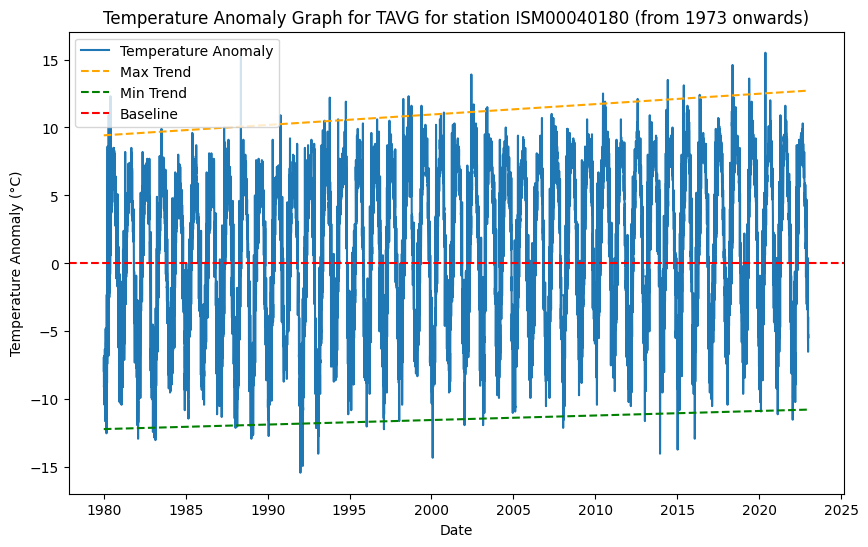

In [22]:
import numpy as np
import matplotlib.dates as mdates

# Choose ISM00040180 station and make sure TAVG column is numeric
df = data[data['STATION'] == 'ISM00040180'].copy()
df['TAVG'] = pd.to_numeric(df['TAVG'], errors='coerce')

# Convert DATE to datetime
df['DATE'] = pd.to_datetime(df['DATE'])

# Calculate the 'baseline' for 1951-1980
baseline_df = df[(df['DATE'].dt.year >= 1951) & (df['DATE'].dt.year <= 1980)]
baseline = baseline_df['TAVG'].mean()

# Filter data from 1973 and later
df = df[df['DATE'].dt.year >= 1980]

# Calculate the anomalies
df['Anomaly'] = df['TAVG'] - baseline

# Convert DATE to numeric for calculations
df['DATE_num'] = mdates.date2num(df['DATE'])

# Calculate trend lines
df_max = df.groupby(df['DATE'].dt.year)['Anomaly'].idxmax()
df_min = df.groupby(df['DATE'].dt.year)['Anomaly'].idxmin()

# Top trend
max_coeffs = np.polyfit(df.loc[df_max, 'DATE_num'], df.loc[df_max, 'Anomaly'], 1)
max_trend = max_coeffs[0] * df['DATE_num'] + max_coeffs[1]

# Bottom trend
min_coeffs = np.polyfit(df.loc[df_min, 'DATE_num'], df.loc[df_min, 'Anomaly'], 1)
min_trend = min_coeffs[0] * df['DATE_num'] + min_coeffs[1]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df['DATE'], df['Anomaly'], label='Temperature Anomaly')
plt.plot(df['DATE'], max_trend, color='orange', linestyle='--', label='Max Trend')
plt.plot(df['DATE'], min_trend, color='green', linestyle='--', label='Min Trend')
plt.axhline(0, color='red', linestyle='--', label='Baseline')  # This adds a horizontal line
plt.xlabel('Date')
plt.ylabel('Temperature Anomaly (°C)')
plt.title('Temperature Anomaly Graph for TAVG for station ISM00040180 (from 1973 onwards)')
plt.legend()
plt.show()







In [18]:
max_trend

array([ 8.79328122,  8.8340175 ,  8.87475378,  9.11917147,  9.15990775,
        9.20064403,  9.24138032,  9.2821166 ,  9.32285288,  9.36358916,
        9.40432544,  9.44506172,  9.485798  ,  9.52653428,  9.56727056,
        9.60800685,  9.64874313,  9.68947941,  9.73021569,  9.77095197,
       10.01536966, 10.05610594, 10.09684222, 10.1375785 , 10.17831478,
       10.21905106, 10.25978734, 10.30052363, 10.34125991, 10.38199619,
       10.42273247, 10.46346875, 10.50420503, 10.54494131, 10.58567759,
       10.62641388, 10.66715016, 10.70788644, 10.74862272, 10.789359  ,
       10.83009528, 10.87083156, 10.91156784, 10.95230412, 10.99304041,
       11.03377669, 11.07451297, 11.11524925, 11.15598553, 11.19672181,
       11.23745809, 11.27819437, 11.31893066, 11.35966694, 11.40040322,
       11.4411395 , 11.48187578, 11.52261206, 11.56334834, 11.60408462,
       11.6448209 , 11.68555719, 11.72629347, 11.76702975, 11.80776603,
       11.84850231, 11.88923859, 11.92997487, 11.97071115, 12.01

The code filters temperature data for a specific station - ISM00040180, calculates the annual mean temperatures, normalizes the temperatures, and creates a climate stripe plot using matplotlib and numpy to visualize the temperature variations over the years. Each stripe represents a year, and the color of each stripe is based on the normalized temperature.

The np.nanmean() function is used to calculate the annual mean temperatures by averaging each row (year) of the data_df array along the rows (axis=1). The result is assigned to the variable mean_temps.

The mean temperatures are normalized to the range [0,1] using the formula (mean_temps - mean_temps.min()) / (mean_temps.max() - mean_temps.min()). The normalized temperatures are assigned to the variable norm_temps.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Filter the data for the station of interest.
df = data[data['STATION'] == 'ISM00040180'].copy()

# Sort the data by date.
df = df.sort_values('DATE')

# Group by year and apply list to each group's TAVG column.
grouped = df.groupby(df['DATE'].str[:4])['TAVG'].apply(list)

# Create a list of lists where each sublist represents a year
list_data = [v + [np.nan] * (366 - len(v)) for v in grouped.values]

# Convert the list of lists to a 2D numpy array
data_df = np.array(list_data)

# Calculate annual mean temperatures.
mean_temps = np.nanmean(data_df, axis=1)

# Normalize to [0,1] range.
norm_temps = (mean_temps - mean_temps.min()) / (mean_temps.max() - mean_temps.min())

print(norm_temps)
print(grouped.keys())

# Create a figure and axes.
fig, ax = plt.subplots(figsize=(10, 6))

# Draw each year's stripe.
for i, t in enumerate(norm_temps):
    # Map [0,1] range to colors.
    color = (t, 0, 1 - t)

    # Draw the stripe.
    rect = plt.Rectangle((i, 0), 1, 1, facecolor=color)
    ax.add_patch(rect)

# Set up the axes.
ax.set_xlim(0, len(norm_temps))
ax.set_ylim(0, 1)

# Get list of years
years = list(grouped.keys())

# Set x-ticks every 5 years
plt.xticks(range(0, len(years), 5), years[::5])

plt.show()




NameError: name 'data' is not defined